# Fase 1: Importar las dependencias

**Paper original**: All you need is Attention https://arxiv.org/pdf/1706.03762.pdf

In [ ]:
import numpy as np
import math
import re
import time
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Fase 2: Pre Procesado de Datos



## Carga de Ficheros

Importamos los ficheros de nuestro Google Drive personal

In [ ]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
with open("/content/drive/My Drive/Curso de NLP/Transformer/data/europarl-v7.es-en.en", 
          mode = "r", encoding = "utf-8") as f:
    europarl_en = f.read()
with open("/content/drive/My Drive/Curso de NLP/Transformer/data/europarl-v7.es-en.es", 
          mode = "r", encoding = "utf-8") as f:
    europarl_es = f.read()
with open("/content/drive/My Drive/Curso de NLP/Transformer/data/nonbreaking_prefix.en", 
          mode = "r", encoding = "utf-8") as f:
    non_breaking_prefix_en = f.read()
with open("/content/drive/My Drive/Curso de NLP/Transformer/data/nonbreaking_prefix.en", 
          mode = "r", encoding = "utf-8") as f:
    non_breaking_prefix_es = f.read()

In [ ]:
europarl_en[:100]

'Resumption of the session\nI declare resumed the session of the European Parliament adjourned on Frid'

In [ ]:
europarl_es[:100]

'Reanudación del período de sesiones\nDeclaro reanudado el período de sesiones del Parlamento Europeo,'

## Limpieza de datos

Vamos a obtener los non_breaking_prefixes como una lista de palabras limpias con un punto al final para que nos sea más fácil de utilizar.

In [ ]:
non_breaking_prefix_en = non_breaking_prefix_en.split("\n")
non_breaking_prefix_en = [' ' + pref + '.' for pref in non_breaking_prefix_en]
non_breaking_prefix_es = non_breaking_prefix_es.split("\n")
non_breaking_prefix_es = [' ' + pref + '.' for pref in non_breaking_prefix_es]

Necesitaremos cada palabra y otro símbolo que queramos mantener en minúsculas y separados por espacios para que podamos "tokenizarlos".

In [ ]:
corpus_en = europarl_en
# Añadimos $$$ después de los puntos de frases sin fin
for prefix in non_breaking_prefix_en:
    corpus_en = corpus_en.replace(prefix, prefix + '$$$')
corpus_en = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_en)
# Eliminamos los marcadores $$$
corpus_en = re.sub(r"\.\$\$\$", '', corpus_en)
# Eliminamos espacios múltiples
corpus_en = re.sub(r"  +", " ", corpus_en)
corpus_en = corpus_en.split('\n')

corpus_es = europarl_es
for prefix in non_breaking_prefix_es:
    corpus_es = corpus_es.replace(prefix, prefix + '$$$')
corpus_es = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_es)
corpus_es = re.sub(r"\.\$\$\$", '', corpus_es)
corpus_es = re.sub(r"  +", " ", corpus_es)
corpus_es = corpus_es.split('\n')

In [ ]:
import pandas as pd
corpus_en=pd.read_csv("/content/drive/My Drive/Curso de NLP/Transformer/data/corpus_en.csv").values
corpus_es=pd.read_csv("/content/drive/My Drive/Curso de NLP/Transformer/data/corpus_es.csv").values

## Tokenizar el Texto

In [ ]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    corpus_en, target_vocab_size=2**13)
tokenizer_es = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    corpus_es, target_vocab_size=2**13)

In [ ]:
VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2 # = 8198
VOCAB_SIZE_ES = tokenizer_es.vocab_size + 2 # = 8225

In [ ]:
inputs = [[VOCAB_SIZE_EN-2] + tokenizer_en.encode(sentence) + [VOCAB_SIZE_EN-1]
          for sentence in corpus_en]
outputs = [[VOCAB_SIZE_ES-2] + tokenizer_es.encode(sentence) + [VOCAB_SIZE_ES-1]
           for sentence in corpus_es]

## Eliminamos las frases demasiado largas

In [ ]:
MAX_LENGTH = 20
idx_to_remove = [count for count, sent in enumerate(inputs)
                 if len(sent) > MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]
idx_to_remove = [count for count, sent in enumerate(outputs)
                 if len(sent) > MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]

In [ ]:
import pandas as pd
pd.DataFrame(inputs).to_csv("/content/drive/My Drive/Curso de NLP/Transformer/data/inputs.csv", index=False)
pd.DataFrame(outputs).to_csv("/content/drive/My Drive/Curso de NLP/Transformer/data/outputs.csv", index=False)

## Creamos las entradas y las salidas

A medida que entrenamos con bloques, necesitaremos que cada entrada tenga la misma longitud. Rellenamos con el token apropiado, y nos aseguraremos de que este token de relleno no interfiera con nuestro entrenamiento más adelante.

In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=MAX_LENGTH)
outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=MAX_LENGTH)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Fase 3: Construcción del Modelo

## Embedding

Fórmula de la Codificación Posicional:

$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

In [ ]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        pos_encoding = angles[np.newaxis, ...]
        return inputs + tf.cast(pos_encoding, tf.float32)

## Attention

### Cálculo de la Atención

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $

In [ ]:
def scaled_dot_product_attention(queries, keys, values, mask):
    product = tf.matmul(queries, keys, transpose_b=True)
    
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    scaled_product = product / tf.math.sqrt(keys_dim)
    
    if mask is not None:
        scaled_product += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_product, axis=-1)

    attention = tf.matmul(attention_weights, values)
    
    return attention, attention_weights

### Sub capa de atención de encabezado múltiple

In [ ]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, nb_proj):
        super(MultiHeadAttention, self).__init__()
        self.nb_proj = nb_proj
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.nb_proj == 0
        
        self.d_proj = self.d_model // self.nb_proj
        
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        shape = (batch_size,
                 -1,
                 self.nb_proj,
                 self.d_proj)
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        batch_size = tf.shape(queries)[0]
        
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        
        attention, attention_weights = scaled_dot_product_attention(queries, keys, values, mask)
        
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        
        outputs = self.final_lin(concat_attention)
        
        return outputs, attention_weights

## Codificación

In [ ]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate):
        super(EncoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        attention, _ = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        attention = self.norm_1(attention + inputs)
        
        outputs = self.dense_1(attention)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [ ]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.nb_layers = nb_layers
        self.d_model = d_model
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        for i in range(self.nb_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

## Descodificación

In [ ]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Self multi head attention
        self.multi_head_attention_1 = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention combinado con la salida del encoder 
        self.multi_head_attention_2 = MultiHeadAttention(self.nb_proj)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.dense_1 = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        attention, attention_weights_1 = self.multi_head_attention_1(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training)
        attention = self.norm_1(attention + inputs)
        
        attention_2, attention_weights_2 = self.multi_head_attention_2(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        attention_2 = self.norm_2(attention_2 + attention)
        
        outputs = self.dense_1(attention_2)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_3(outputs, training)
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs, attention_weights_1, attention_weights_2

In [ ]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.nb_layers = nb_layers
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        
        self.dec_layers = [DecoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        att_weights = {}

        for i in range(self.nb_layers):
            outputs, att_weights_self, att_weights_cross = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training)
            att_weights["decoder_layer_{}_self".format(i+1)] = att_weights_self
            att_weights["decoder_layer_{}_cross".format(i+1)] = att_weights_cross

        return outputs, att_weights

## Transformer

In [ ]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        self.decoder = Decoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq): #seq: (batch_size, seq_length)
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        enc_mask = self.create_padding_mask(enc_inputs)
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        dec_outputs, att_weights = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training)
        
        outputs = self.last_linear(dec_outputs)
        
        return outputs, att_weights

# Entrenamiento

In [ ]:
tf.keras.backend.clear_session()

# Hiper Parámetros
D_MODEL = 128 # 512
NB_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
NB_PROJ = 8 # 8
DROPOUT_RATE = 0.1 # 0.1

transformer = Transformer(vocab_size_enc=VOCAB_SIZE_EN,
                          vocab_size_dec=VOCAB_SIZE_ES,
                          d_model=D_MODEL,
                          nb_layers=NB_LAYERS,
                          FFN_units=FFN_UNITS,
                          nb_proj=NB_PROJ,
                          dropout_rate=DROPOUT_RATE)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")

def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

leaning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
        

In [ ]:
checkpoint_path = "./drive/My Drive/Curso de NLP/Transformer/ckpt/"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Último checkpoint restaurado!!")

Último checkpoint restaurado!!


In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print("Inicio del epoch {}".format(epoch+1))
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        dec_inputs = targets[:, :-1]
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
            predictions, _ = transformer(enc_inputs, dec_inputs, True)
            loss = loss_function(dec_outputs_real, predictions)
        
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % 50 == 0:
            print("Epoch {} Lote {} Pérdida {:.4f} Precisión {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
    ckpt_save_path = ckpt_manager.save()
    print("Guardando checkpoint para el epoch {} en {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Tiempo que ha tardado 1 epoch: {} segs\n".format(time.time() - start))

Inicio del epoch 1
Epoch 1 Lote 0 Pérdida 5.7712 Precisión 0.0000
Epoch 1 Lote 50 Pérdida 6.0703 Precisión 0.0008
Epoch 1 Lote 100 Pérdida 6.0209 Precisión 0.0249
Epoch 1 Lote 150 Pérdida 5.9672 Precisión 0.0341
Epoch 1 Lote 200 Pérdida 5.8880 Precisión 0.0388
Epoch 1 Lote 250 Pérdida 5.7829 Precisión 0.0431
Epoch 1 Lote 300 Pérdida 5.6780 Precisión 0.0512
Epoch 1 Lote 350 Pérdida 5.5599 Precisión 0.0575
Epoch 1 Lote 400 Pérdida 5.4499 Precisión 0.0622
Epoch 1 Lote 450 Pérdida 5.3427 Precisión 0.0662
Epoch 1 Lote 500 Pérdida 5.2409 Precisión 0.0704
Epoch 1 Lote 550 Pérdida 5.1469 Precisión 0.0750
Epoch 1 Lote 600 Pérdida 5.0560 Precisión 0.0796
Epoch 1 Lote 650 Pérdida 4.9704 Precisión 0.0841
Epoch 1 Lote 700 Pérdida 4.8874 Precisión 0.0882
Epoch 1 Lote 750 Pérdida 4.8114 Precisión 0.0924
Epoch 1 Lote 800 Pérdida 4.7401 Precisión 0.0967
Epoch 1 Lote 850 Pérdida 4.6730 Precisión 0.1008
Epoch 1 Lote 900 Pérdida 4.6113 Precisión 0.1048
Epoch 1 Lote 950 Pérdida 4.5494 Precisión 0.1086
Epoc

# Evaluación

In [ ]:
def evaluate(inp_sentence):
    inp_sentence = \
        [VOCAB_SIZE_EN-2] + tokenizer_en.encode(inp_sentence) + [VOCAB_SIZE_EN-1]
    enc_input = tf.expand_dims(inp_sentence, axis=0)
    
    output = tf.expand_dims([VOCAB_SIZE_ES-2], axis=0)
    
    for _ in range(MAX_LENGTH):
        predictions, attention_weights = transformer(enc_input, output, False) #(1, seq_length, VOCAB_SIZE_ES)
        
        prediction = predictions[:, -1:, :]
        
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        
        if predicted_id == VOCAB_SIZE_ES-1:
            return tf.squeeze(output, axis=0), attention_weights
        
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_en.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
    
        ax.matshow(attention[head][:-1, :])

        fontdict = {'fontsize': 10,
                    'color': 'black'} 
    
        ax.set_xticks(range(len(sentence)))
        ax.set_yticks(range(len(result)))
    
        ax.set_ylim(len(result)-1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>']+[tokenizer_en.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
    
        ax.set_yticklabels([tokenizer_es.decode([i]) for i in result 
                            if i < tokenizer_es.vocab_size], 
                           fontdict=fontdict)
    
        ax.set_xlabel('Cabecera {}'.format(head+1))

    plt.tight_layout()
    plt.show()

In [ ]:
def translate(sentence, plot=''):
    output, attention_weights = evaluate(sentence)
    
    predicted_sentence = tokenizer_es.decode(
        [i for i in output.numpy() if i < VOCAB_SIZE_ES-2]
    )
    
    print("Entrada: {}".format(sentence))
    print("Traducción predicha: {}".format(predicted_sentence))
    
    if plot:
        plot_attention_weights(attention_weights, sentence, output, plot)

Entrada: I do not know whether this information is correct
Traducción predicha: No sé si esta información es correcta.


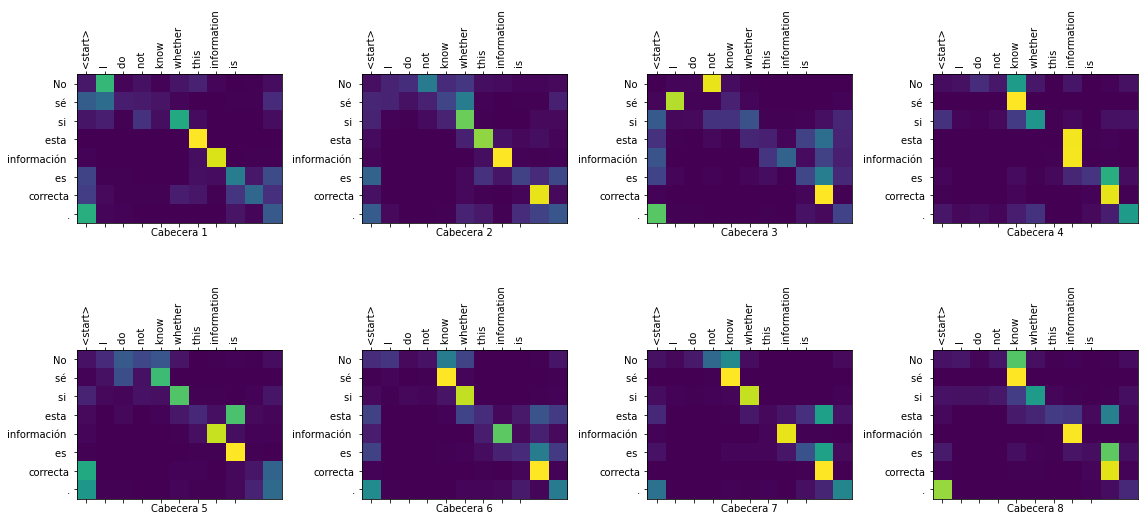

In [ ]:
translate("I do not know whether this information is correct", plot="decoder_layer_4_cross")